In [1]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

import genutils
import os
import sys
import numpy as np
import re
import scipy 
import matplotlib.patches as patches
import glob

/home/jmkidd/kidd-lab/progs/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
####################################################################################
#Defining variables based on script inputs
directory = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Haplotype_Analysis/GenotypeProportions/'
samplefile = directory + '89sample_ancient_Freedman_Lcu2_all_GF_filter_geno0_LabelFile.txt'
propRefAlleleCutoff = float(0.95)
propNonRefAlleleCutoff = float(0.05)


In [3]:
######################################################   
#Opening a summary output file
summaryfile = directory + 'SummaryTable_TotalWildProportions_AllWindows.txt'
summaryFile = open(summaryfile, 'w')
headerLine = 'Window\tProportionCutoff\tWildSamples\tNumberAncientDogs\tNumberBreeds\tNumberVillageDogs\tNumberWolves\tNumberOutgroups\tProp.Dogs\tProp.VillageDogs\tSNPCount\n'
summaryFile.write(headerLine)

summarytable = directory + 'TableOfAllWindows.txt'
summaryTable = open(summarytable, 'w')

In [4]:
######################################################
def write_header(outFile, FST):#file header line
    headerLine = 'SampleID\t0/0\tProp0/0\t0/1\tProp0/1\t1/1\tProp1/1\t%s_RefAlleleCount\t%s_NonRefAlleleCount\n' %(FST,FST)
    outFile.write(headerLine) #writing header line to outfile
######################################################   
def process_samples(samplefile, genoArray):
    #print 'Reading in sample IDs from sample file: ', args.sample_file
    f=open(samplefile,'r')
    sampleCount = 0
    for line in f:
        sampleID = line.rstrip().split('\t')[0]
        line = line.rstrip()
        line = line.split()
        canineType = line[2] #Breed, VillageDog, Wolf, Outgroup, etc.
        sample_array.append(sampleID)
        sampleDict[sampleID] = canineType
        sampleCount += 1
        
        #save sample to dictionary:
        genoArray[sampleID] = []
        
    return sampleDict, genoArray
######################################################   
def setVariables(line):
    numWolves = 0
    numBreeds = 0
    numVillageDogs = 0
    numOutgroups = 0
    numAncient = 0
    numFSTVillageDogs = 0
    return (numWolves, numBreeds, numVillageDogs, numOutgroups, numAncient, numFSTVillageDogs)
######################################################   


In [5]:
genoArray = {}
#print 'Reading in sample IDs from sample file: ', args.sample_file
f=open(samplefile,'r')
sampleCount = 0
for line in f:
    line = line.rstrip()
    line = line.split()
    sample = line[0]
    genoArray[sample] = []

In [8]:
path = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Haplotype_Analysis/results/No_MAF_Filtration/'
filestart = 'CDRExtracted_89sample_ancient_Freedman_Lcu2_all.bim_'

cdrList = []

######################################################
for file in glob.glob(path + '*eigenstratgeno'): #May need to change this to whatever consistent naming you have for all of your bed (PLINK) files (i.e. CDR, FST, filt, etc.)
    filename=file.replace(".eigenstratgeno","")
    CDR=filename.replace(path + filestart,"")
    cdrList.append(CDR)
    inFile = open(file, 'r')
    
    #Creating output file from FST and filename 
    outfile = directory + 'TotalGenotypeProportions_' + CDR + '.txt'
    outFile = open(outfile, 'w')
    write_header(outFile, CDR) #writes header line to outfile defined above
    
    array = []     #Generate array to store all data:
    sample_array = [] #array of sample IDs
    sampleDict = {}
    
    genoList = [] #array of genotypes
    snpCount = 0 #count of SNPs per FST window
        
    for line in inFile:
        line = line.rstrip()
        snpCount += 1
        sampleCount = len(line) #Number of individuals in the analysis = the # of characters in the line
        
        genoList = list(line)
        genoList = ''.join(genoList)
        array.append(map(int,genoList))
    
    print 'Number of SNPs in %s region: %i' % (CDR,snpCount)
    
    #print 'Generated transposed matrix for %i SNPs' % (snpCount)
    matrix=np.array(array) #turns array into a numpy array called 'matrix'
    new_matrix=matrix.T #transposes the original 'matrix' into 'new_matrix' for readability
    
    process_samples(samplefile, genoArray)
    
    new_array = np.array(new_matrix)
    wildArray = []
    nonWildArray = []
    numWolves, numBreeds, numVillageDogs, numOutgroups, numAncient, numFSTVillageDogs  = setVariables(line)

    for i in range(sampleCount):
        missingCount = (new_array[i] == 9).sum() * 2
        #Counting genotypes 0/0, 0/1, 1/1
        sum0 = (new_array[i] == 0).sum()
        prop0 = float(sum0)/snpCount
        sum1 = (new_array[i] == 1).sum()
        prop1 = float(sum1) / snpCount
        sum2 = (new_array[i] == 2).sum()
        prop2 = float(sum2)/ snpCount
        sample = sample_array[i]
        
        #Counting alleles
        ref = int(2*sum0 + sum1)
        nonRef = int(2*sum2 + sum1)
        alleleTotal = ref + nonRef
        refProp = float(ref)/alleleTotal
        nonrefProp = float(nonRef)/alleleTotal

        nonRefProp = float(nonRef)/alleleTotal
        #print ref, nonRef, alleleTotal, missingCount
        if missingCount + alleleTotal != snpCount*2: #check to make sure everything is getting processed corrrectly
            print 'ERROR: Missing sites + sites with data do not add up to total number of SNPs'
        outFile.write('%s\t%i\t%f\t%i\t%f\t%i\t%f\t%f\t%f\n' % (sample, sum0, prop0, sum1, prop1,sum2,prop2, refProp, nonRefProp))
        
        
        if refProp < propRefAlleleCutoff: #Proportion of alleles that are reference (2*0/0 and 1*01)
            wildArray.append(sample)
            if sampleDict[sample] == 'Wolf':
                numWolves += 1
            if sampleDict[sample] == 'Breed':
                numBreeds += 1
            if sampleDict[sample] == 'VillageDog': #All village dogs
                numVillageDogs += 1
            if sampleDict[sample] == 'VillageDog' and 'ID91' not in sample and 'ID60' not in sample: #does not include the village dogs we excluded in our FST analysis due to wolf admixture
                numFSTVillageDogs += 1
            if sampleDict[sample] == 'AncientDog':
                numAncient += 1
            if sampleDict[sample] == 'Coyote' or sampleDict[sample] == 'Jackal' or sampleDict[sample] == 'Fox':
                numOutgroups += 1
        """
        if nonrefProp > propNonRefAlleleCutoff: #Proportion of alleles that are non-reference (2*1/1 and 1*0/1)
            nonWildArray.append(sample)
            if sampleDict[sample] == 'Wolf':
                numWolves += 1
            if sampleDict[sample] == 'Breed':
                numBreeds += 1
            if sampleDict[sample] == 'VillageDog': #All village dogs
                numVillageDogs += 1
            if sampleDict[sample] == 'VillageDog' and 'ID91' not in sample and 'ID60' not in sample: #does not include the village dogs we excluded in our FST analysis due to wolf admixture
                numFSTVillageDogs += 1
            if sampleDict[sample] == 'AncientDog':
                numAncient += 1
            if sampleDict[sample] == 'Coyote' or sampleDict[sample] == 'Jackal' or sampleDict[sample] == 'Fox':
                numOutgroups += 1
        """
    numDogs = numBreeds + numVillageDogs + numAncient
    propDogs = float(numDogs)/80 #There are 80 dogs in the sample set
    propFSTVillageDogs = float(numFSTVillageDogs)/43 #number of village dogs 
    
    #wildIDs = ",".join(wildArray)
    #numWild = len(wildArray)
    nonWildIDs = ",".join(nonWildArray)
    numNonWild = len(nonWildArray)
    #summaryFile.write('%s\t%f\t%s\t%s\t%s\t%s\t%s\t%s\t%f\t%f\t%i\n' % (FST,propRefAlleleCutoff,wildIDs, numAncient, numBreeds, numVillageDogs, numWolves, numOutgroups, propDogs, propFSTVillageDogs, snpCount))
    #print '%s\t%f\t%s\t%s\t%s\t%s\t%s\t%s\t%f\t%f\t%i\n' % (FST,propRefAlleleCutoff,nonWildIDs, numAncient, numBreeds, numVillageDogs, numWolves, numOutgroups,propDogs,propFSTVillageDogs,snpCount)
    outFile.close()

Number of SNPs in CDR11 region: 1000
Number of SNPs in CDR25 region: 3366
Number of SNPs in CDR23 region: 1698
Number of SNPs in CDR27 region: 633
Number of SNPs in CDR20 region: 1109
Number of SNPs in CDR10 region: 398
Number of SNPs in CDR2 region: 915
Number of SNPs in CDR8 region: 1660
Number of SNPs in CDR12 region: 393
Number of SNPs in CDR16 region: 308
Number of SNPs in CDR24 region: 405
Number of SNPs in CDR9 region: 538
Number of SNPs in CDR14 region: 515
Number of SNPs in CDR18 region: 545
Number of SNPs in CDR26 region: 192
Number of SNPs in CDR13 region: 3253
Number of SNPs in CDR22 region: 590
Number of SNPs in CDR1 region: 1661
Number of SNPs in CDR17 region: 322
Number of SNPs in CDR28 region: 413
Number of SNPs in CDR15 region: 596
Number of SNPs in CDR29 region: 465
Number of SNPs in CDR4 region: 327
Number of SNPs in CDR21 region: 341
Number of SNPs in CDR30 region: 432
Number of SNPs in CDR3 region: 321
Number of SNPs in CDR6 region: 35
Number of SNPs in CDR7 region

In [9]:
villageDogCount = 0
ancientDogCount = 0
for i in sampleDict:
    if 'VillageDog' in sampleDict[i]:
        villageDogCount += 1
    if 'Ancient' in sampleDict[i]:
        ancientDogCount += 1
print 'Number of village dogs in our analysis: ', villageDogCount 
print 'Number of ancient dsamples in our analysis: ', ancientDogCount

Number of village dogs in our analysis:  45
Number of ancient dsamples in our analysis:  3


In [26]:
###################################################################
from collections import OrderedDict
refDict = OrderedDict()

f=open(samplefile,'r')
refDict['ID'] = []
refDict['SampleID'] = []
refDict['CanineType'] = []
for line in f:
    sampleID = line.rstrip().split('\t')[0]
    line = line.rstrip()
    line = line.split()
    canineType = line[2] #Breed, VillageDog, Wolf, Outgroup, etc.
    refDict['ID'].append(line[0])
    refDict['SampleID'].append(line[1])
    refDict['CanineType'].append(canineType)

search = directory + 'TotalGenotypeProportions_CDR*.txt'
for file in glob.glob(search):
    FST=file.replace(".txt","")
    FST=FST.replace(directory,"")
    FST=FST.replace('TotalGenotypeProportions_',"")
    
    infile = open(file, 'r')
    refDict[FST] = []
        
    for line in infile:
        line = line.rstrip()
        line = line.split()
        if 'SampleID' in line[0]:
            continue
        refDict[FST].append(line[7])


refAlleleCountfile = directory + 'ReferenceAlelleCounts_AllWindows.txt'
refAlleleCountFile = open(refAlleleCountfile, 'w')

outArray = []
for key in refDict.keys():
    #print 'FST: ', key
    refAlleleCountFile.write('%s\t'%key)
    #for FST in refDict[key]:
    outLine = "\t".join(refDict[key])
    #print outLine
    refAlleleCountFile.write('%s\n'%outLine)
    
    outArray.append(refDict[key])
matrix=np.array(outArray) #turns array into a numpy array called 'matrix'
new_matrix=matrix.T


#Invert of previous outfile
refAlleleCountfile_inv = directory + 'ReferenceAlelleCounts_AllWindows_Inverted.txt'
refAlleleCountFile_inv = open(refAlleleCountfile_inv, 'w')

refAlleleCountFile_inv.write('SampleID\tSampleDescription\t')
for i in cdrList:
    refAlleleCountFile_inv.write('%s\t'% (i))
refAlleleCountFile_inv.write('\n')



In [11]:
#Determining the order I want to plot the dogs in for the bar plot for reference allele proportions
RDplotOrder = []

#inFile = open('sample-plot-order.txt')
inFile = open('/home/ampend/kidd-lab/ampend-projects/Angela/amy2b/input/' + 'rd-sample-plot-order-2.txt')
for line in inFile:
    line = line.rstrip()
    line = line.split('\t')
    if 'Lcu' in line[0]:
        continue
    if 'ysb' in line[0]:
        continue
    RDplotOrder.append([line[0],line[1],line[2],line[3],line[4]])
inFile.close()

In [50]:
#Determining the order I want to plot the dogs in for the bar plot for reference allele proportions
fstDogs = []

inFile = open('/home/jmkidd/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Haplotype_Analysis/GenotypeProportions/input/GenomeSampleInfoTable-VillageGreyWolves_lowAdmix.txt', 'r')
for line in inFile:
    line = line.rstrip()
    line = line.split('\t')
    if 'Lcu' in line[0]:
        continue
    if 'ysb' in line[0]:
        continue
    if 'pen' in line[0]:
        fstDogs.append('IBW')
        continue
    fstDogs.append(line[0])
    #fstDogs.append([line[0],line[1],line[2]])
inFile.close()

In [29]:
propData = {}

infile = open('/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Haplotype_Analysis/GenotypeProportions/ReferenceAlelleCounts_AllWindows.txt','r')

for line in infile:
    line = line.rstrip().split('\t')
    if 'ID' in line and 'SampleID' not in line:
        dogs = line[1:]
    if 'CDR' in line[0]:
        CDR = line[0]
        propData[CDR] = line[1:]


In [14]:
#obtain reference allele proportion for a given cdr region
def get_ref_prop(dog,data):
    for w in data[dog]:
        ref_prop = float(w)
        return ref_prop


CDR9
CDR8
CDR3
CDR2
CDR1
CDR7
CDR6
CDR5
CDR4
CDR30
CDR19
CDR18
CDR17
CDR16
CDR15
CDR14
CDR13
CDR12
CDR11
CDR10
CDR22
CDR23
CDR20
CDR21
CDR26
CDR27
CDR24
CDR25
CDR28
CDR29


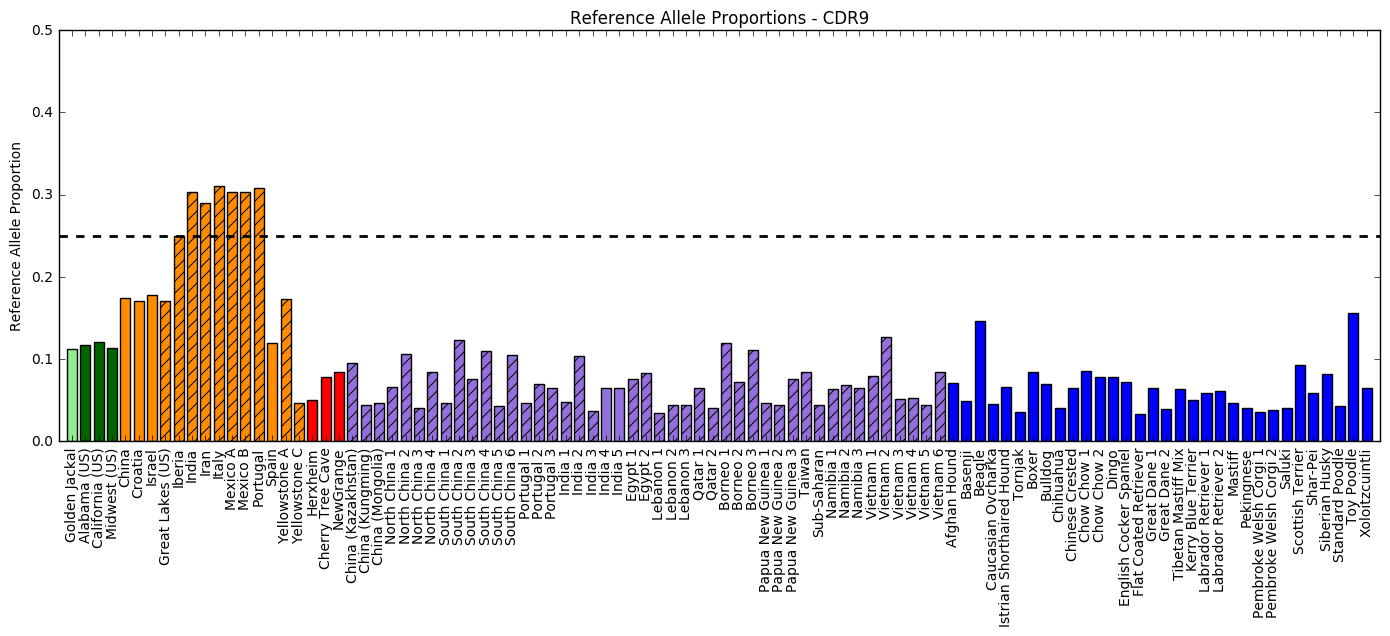

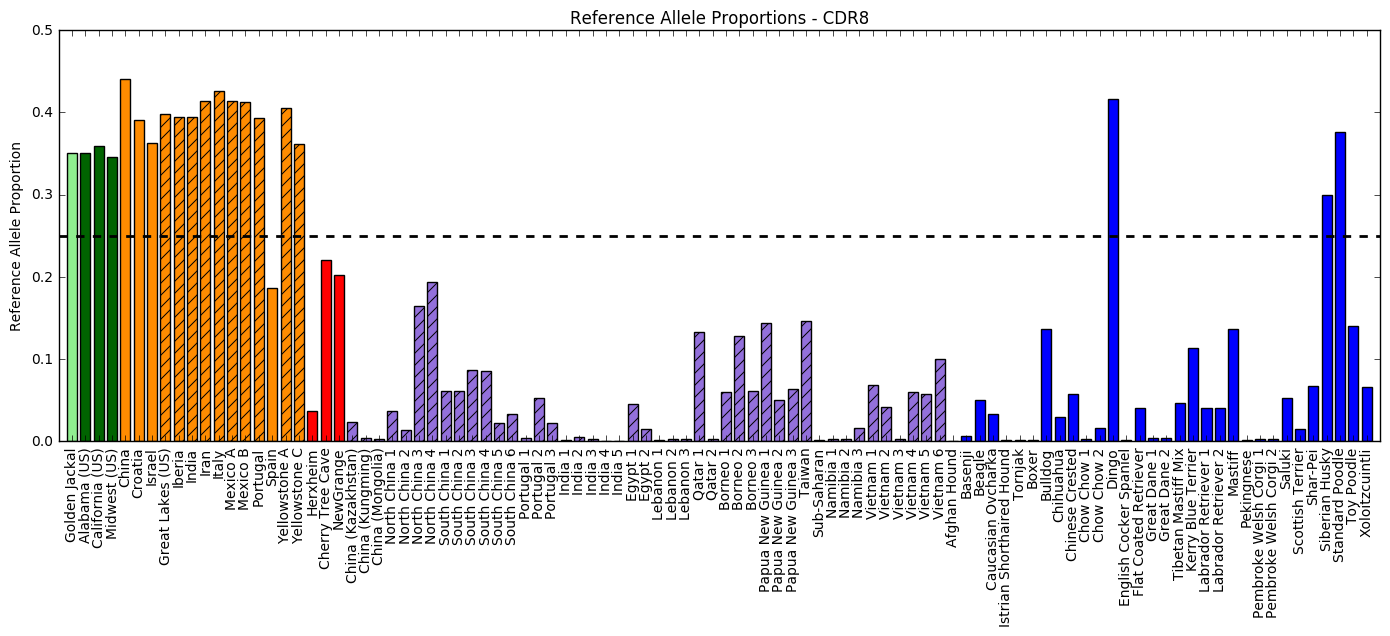

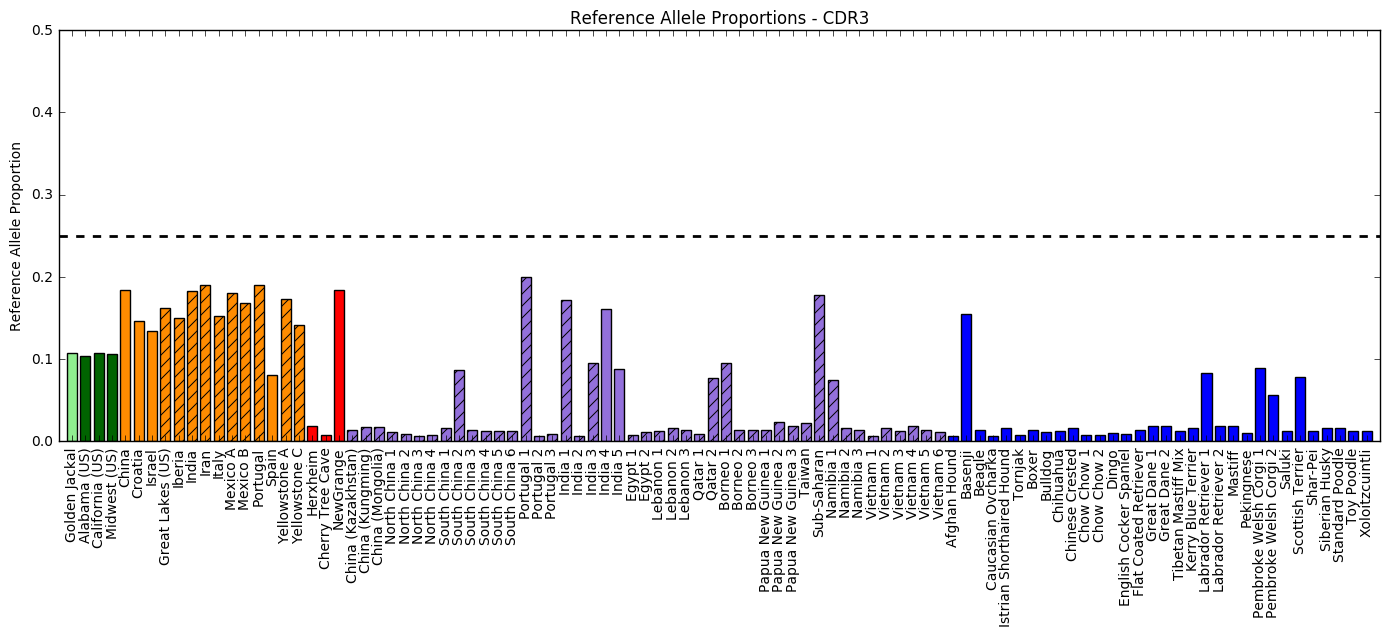

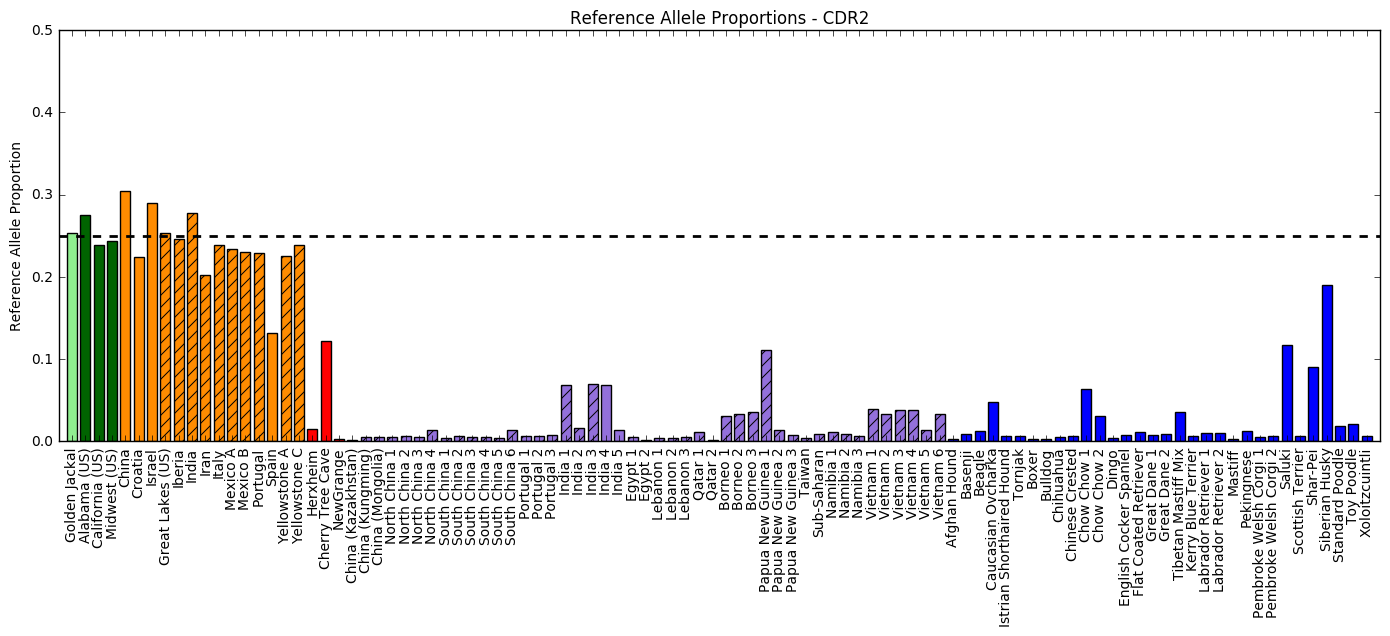

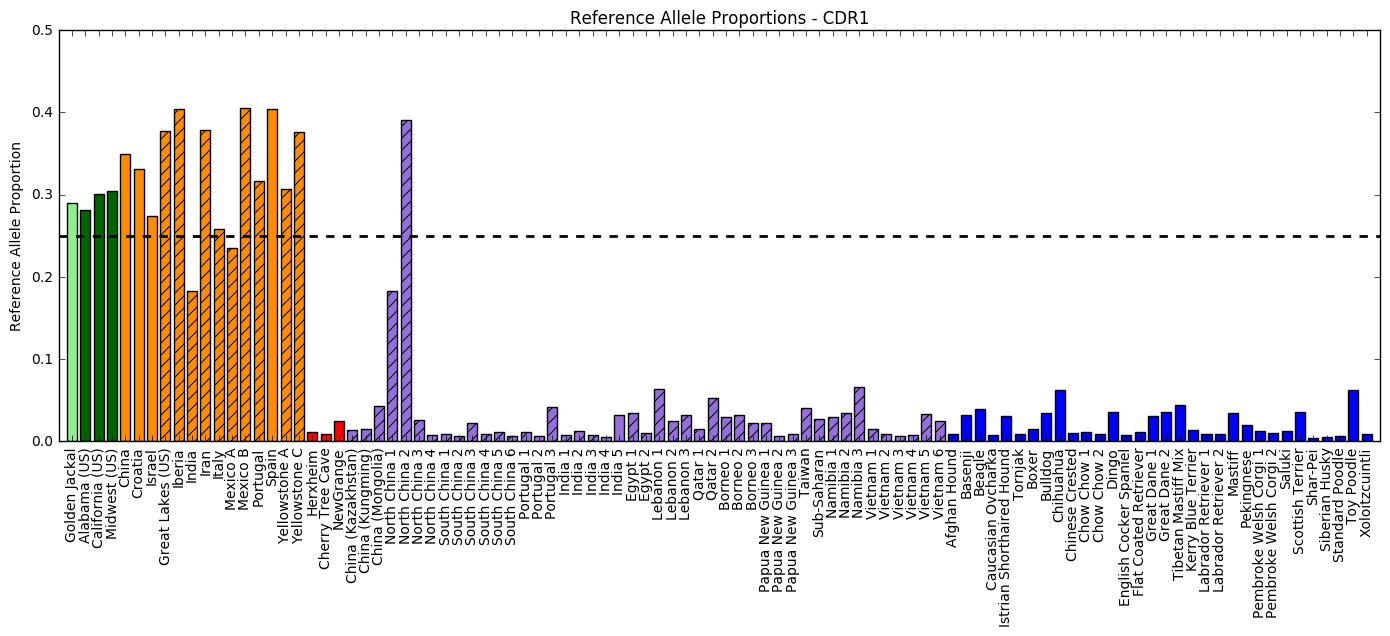

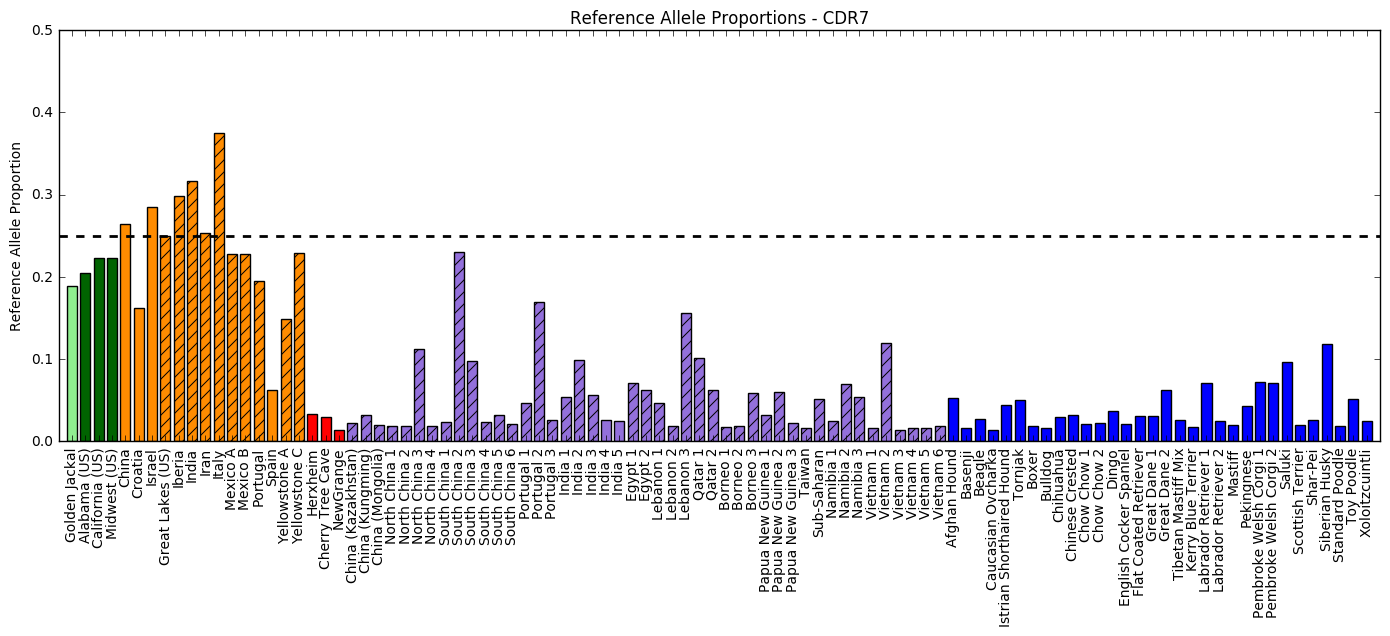

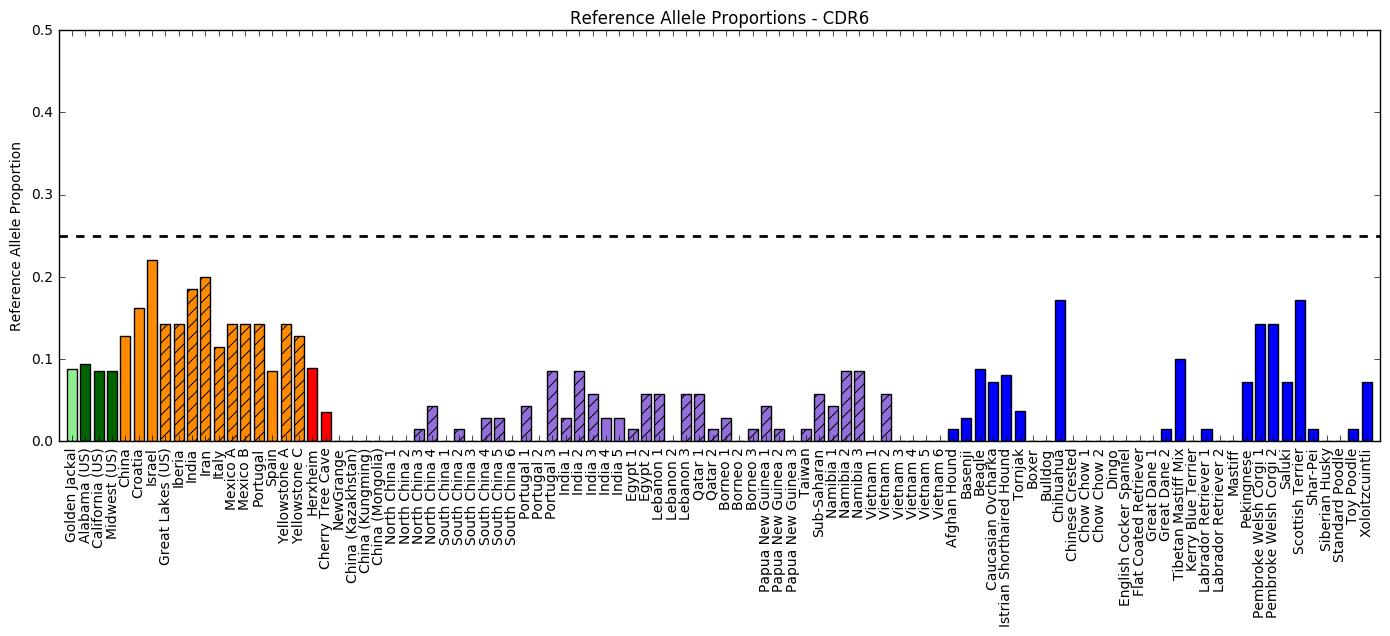

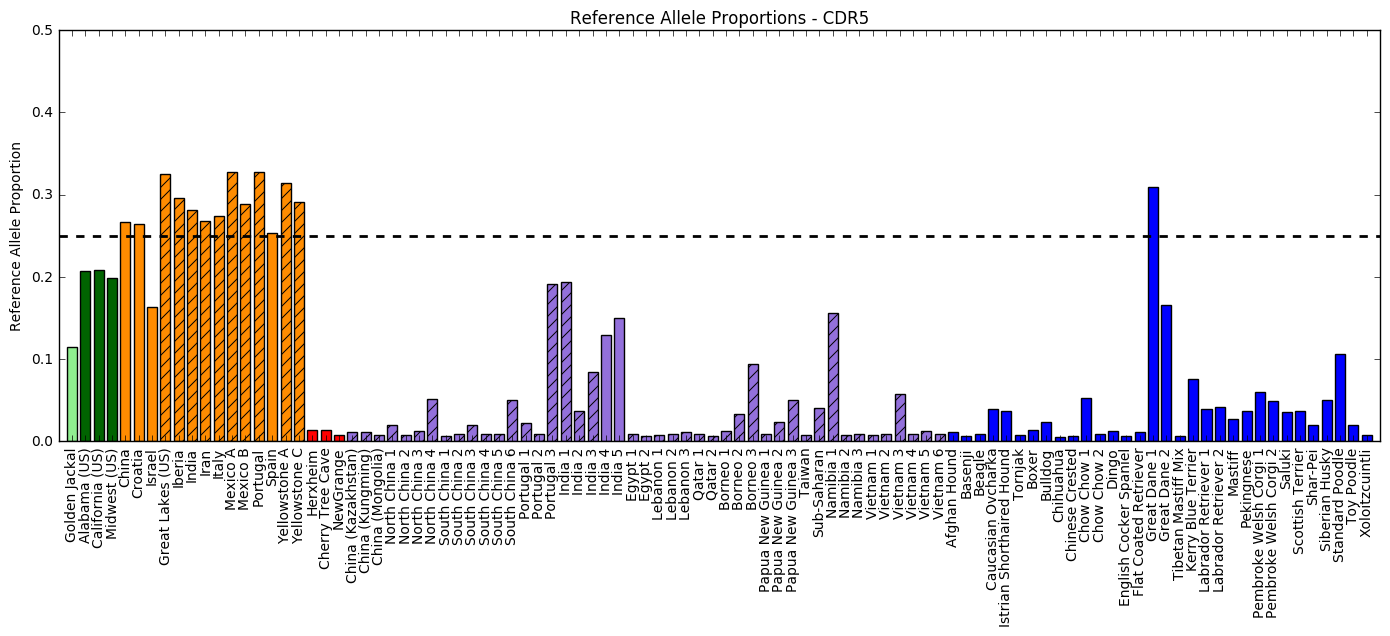

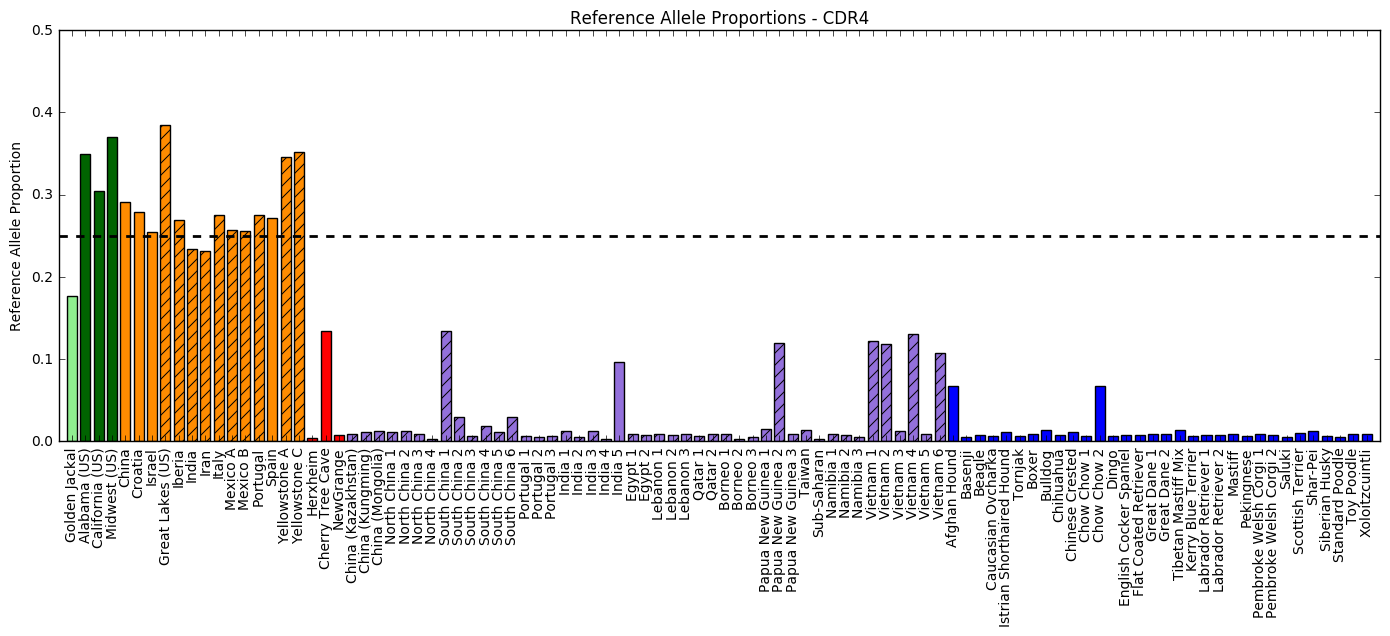

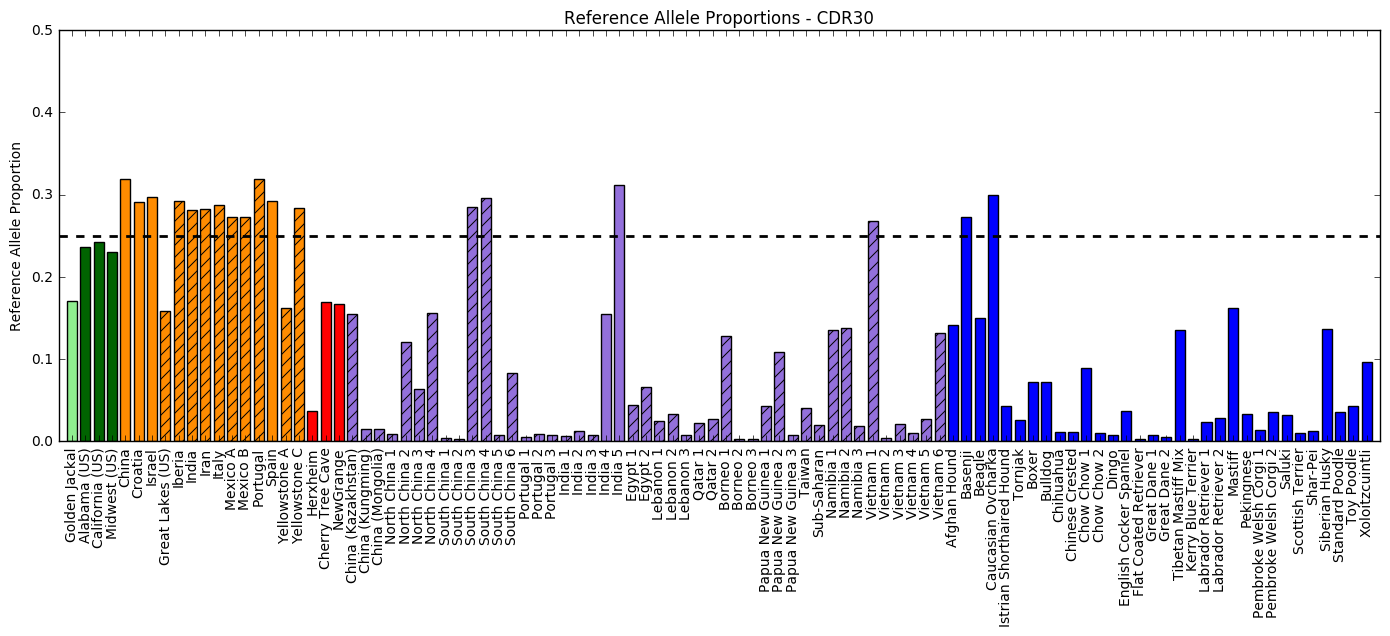

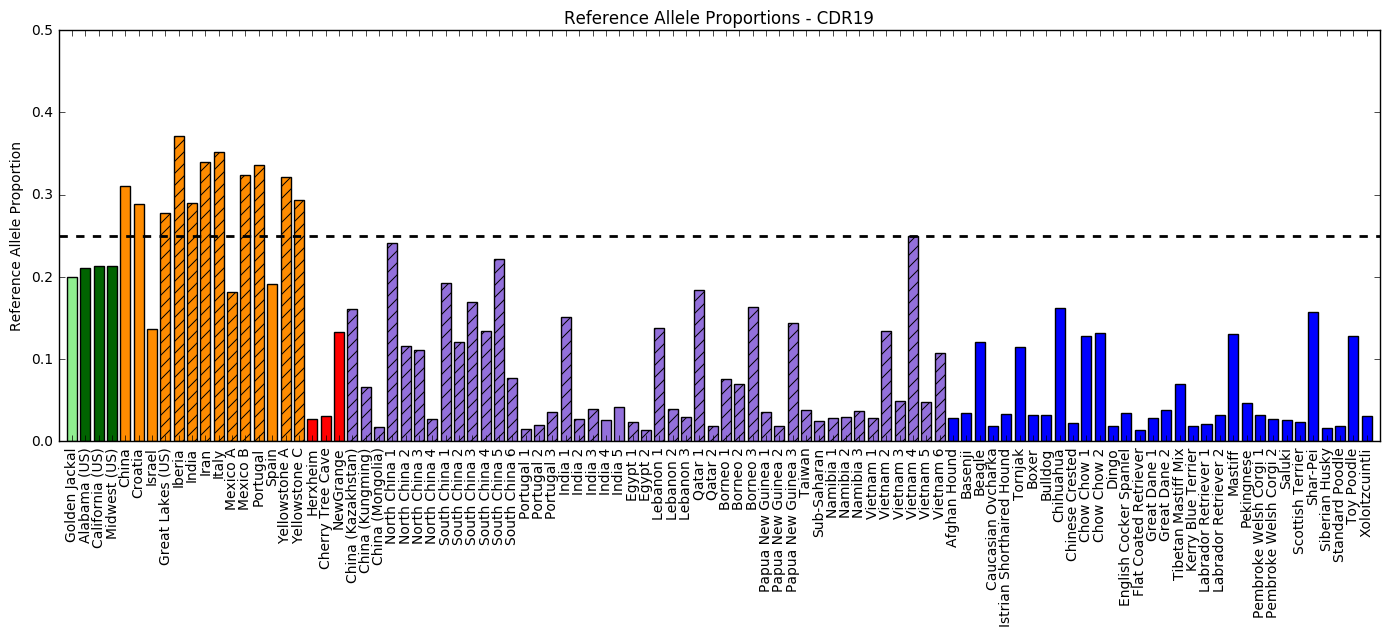

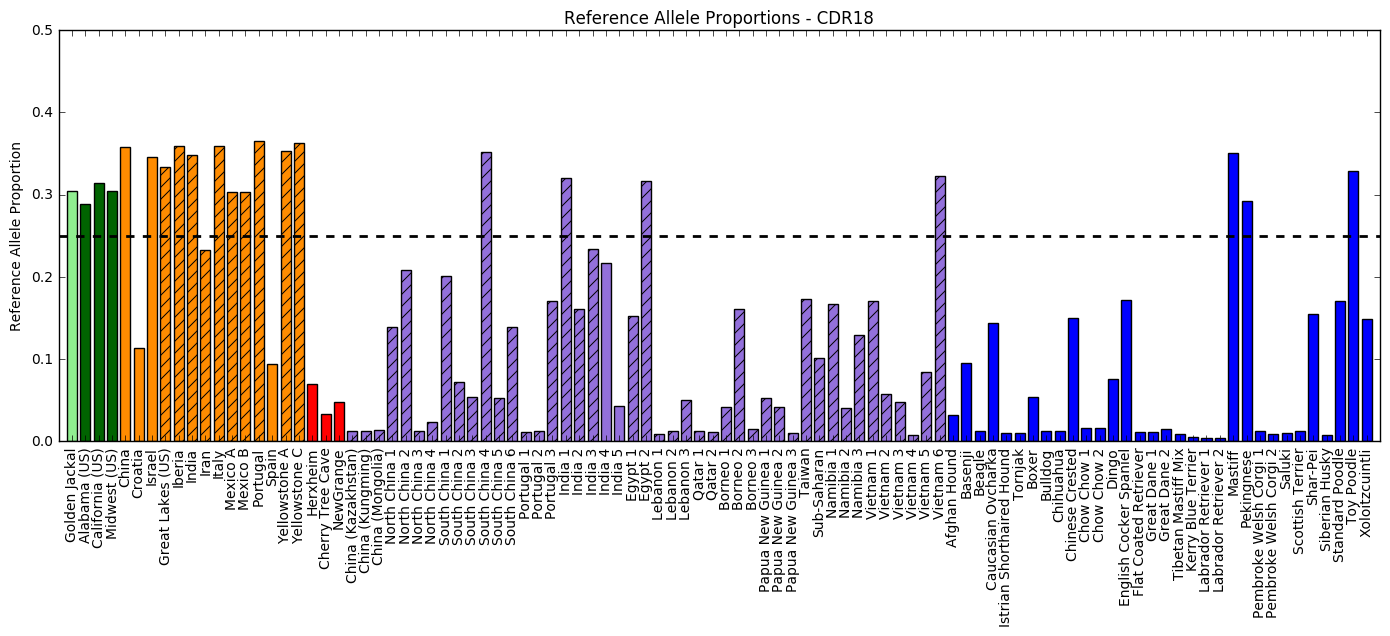

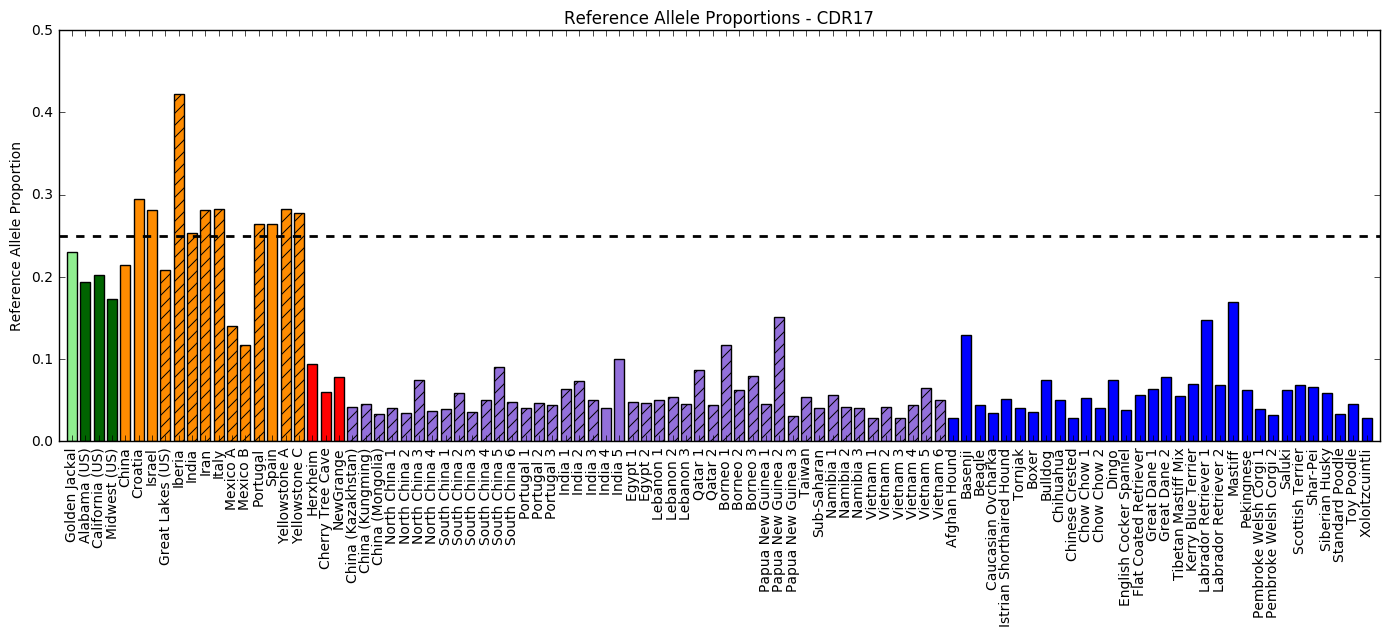

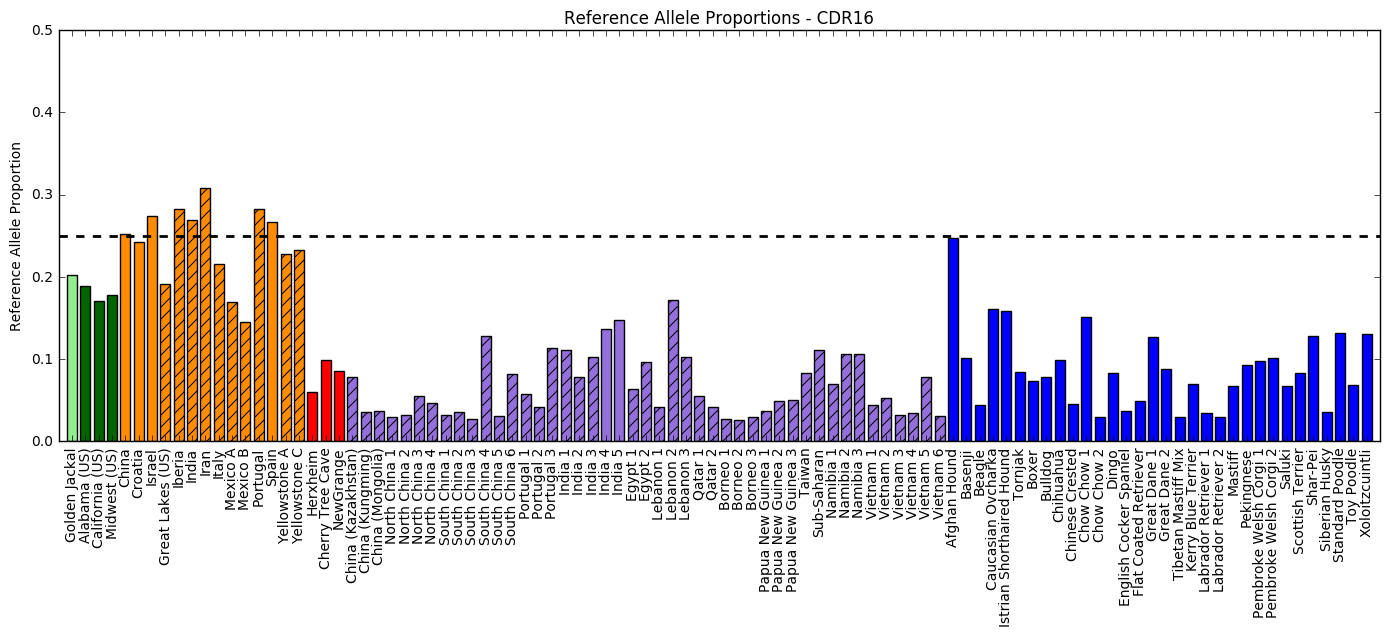

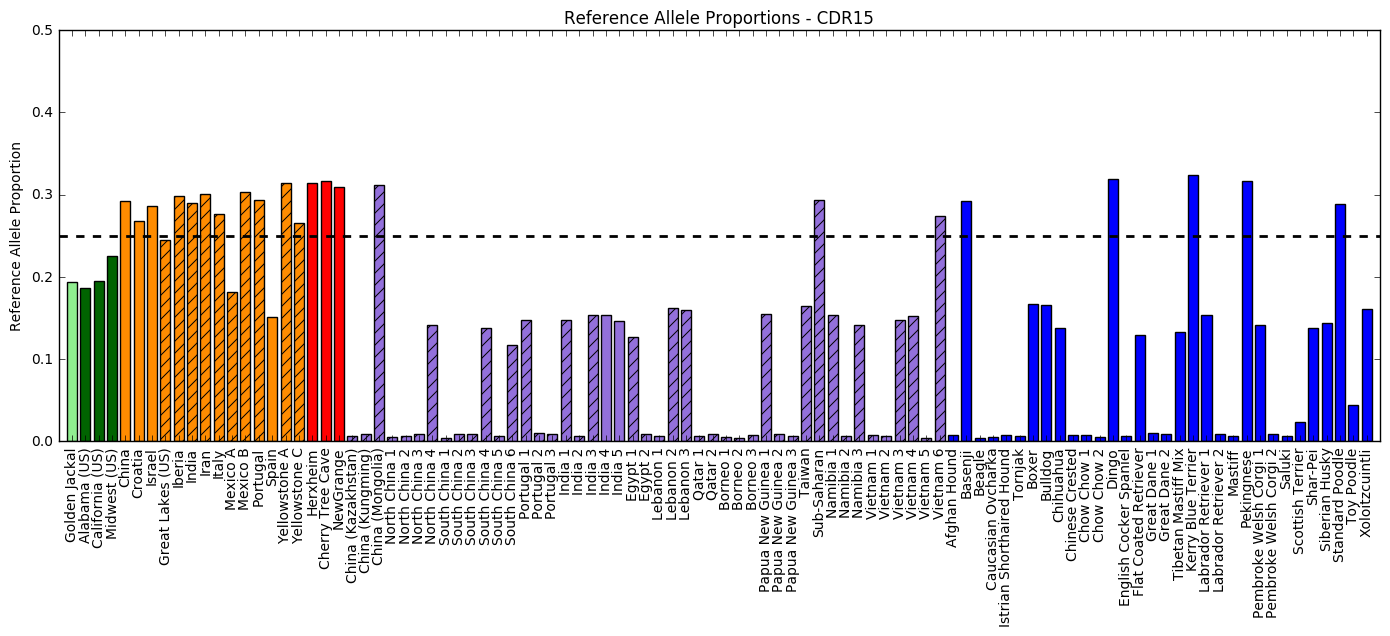

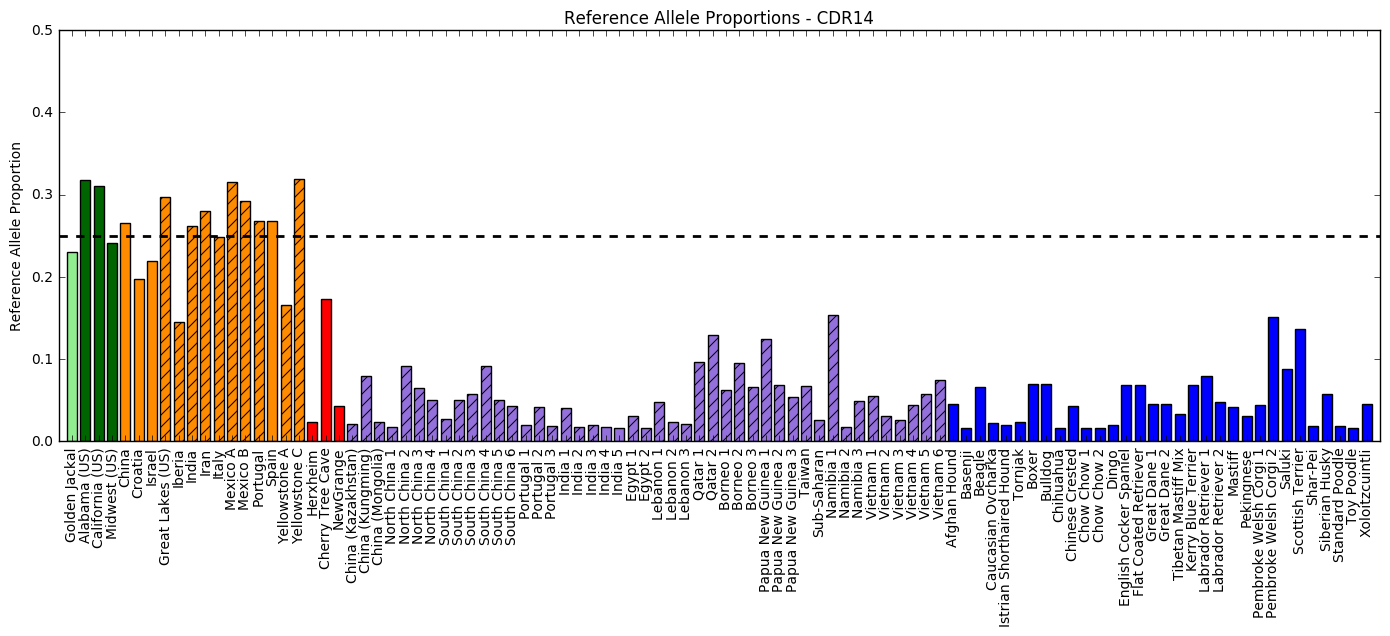

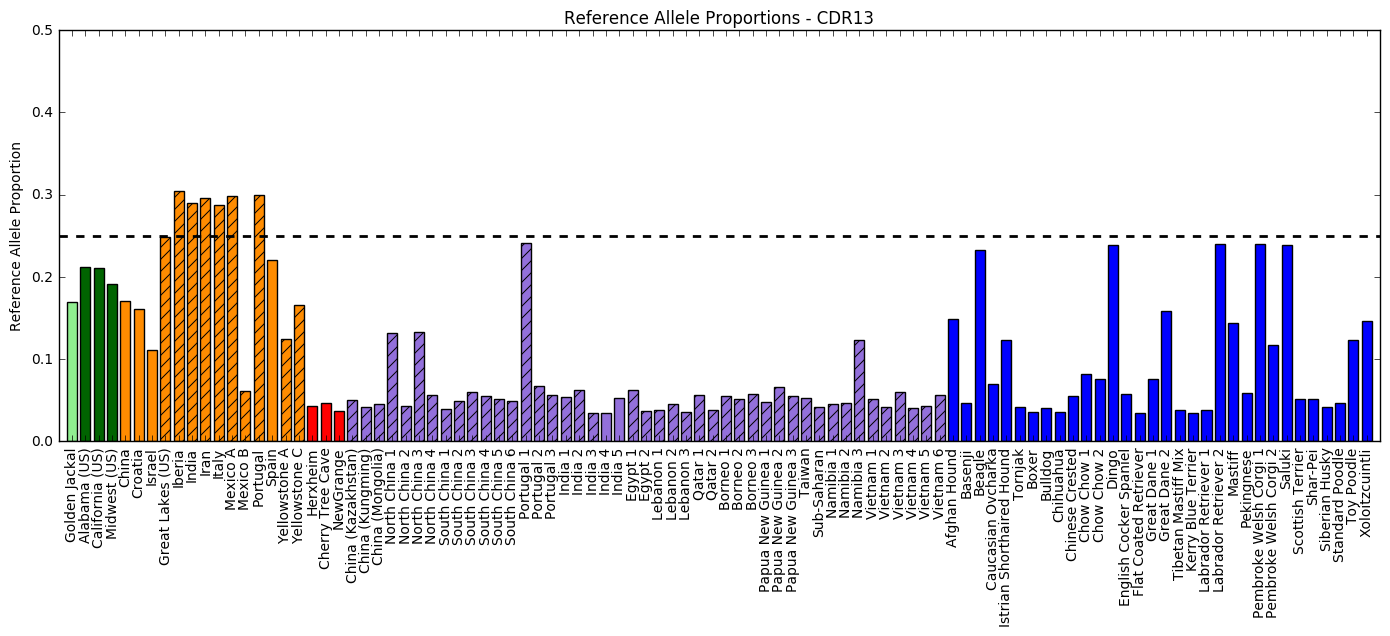

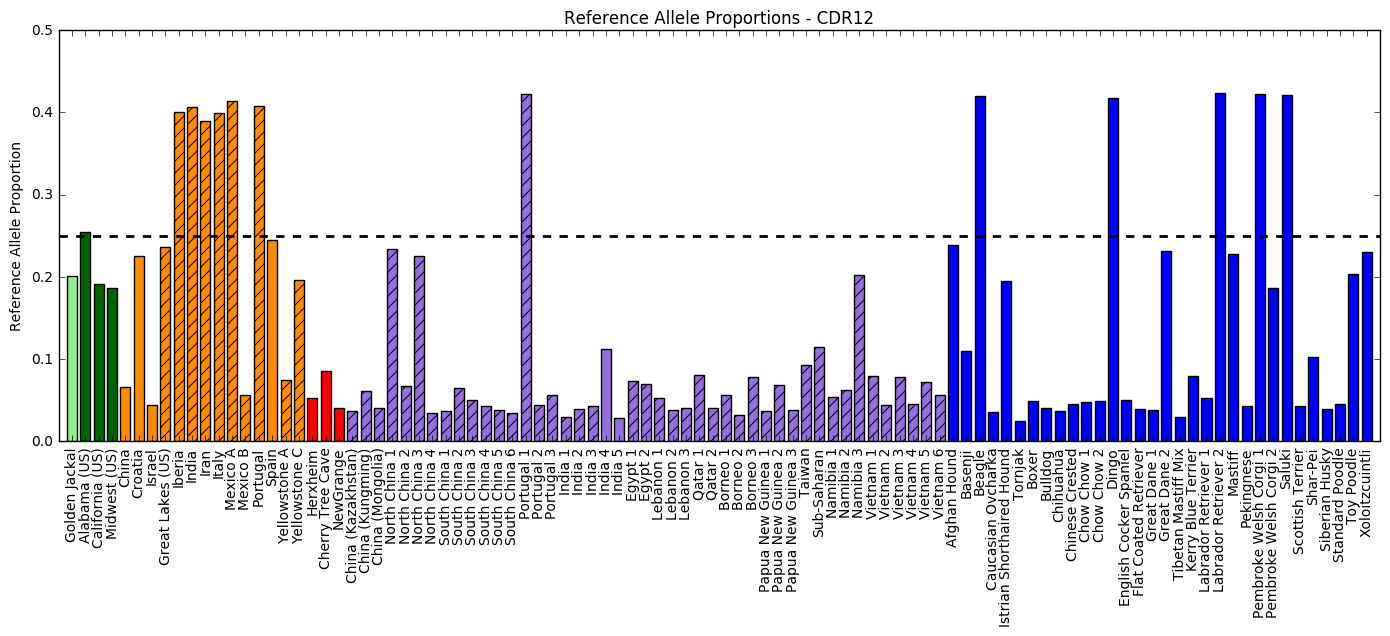

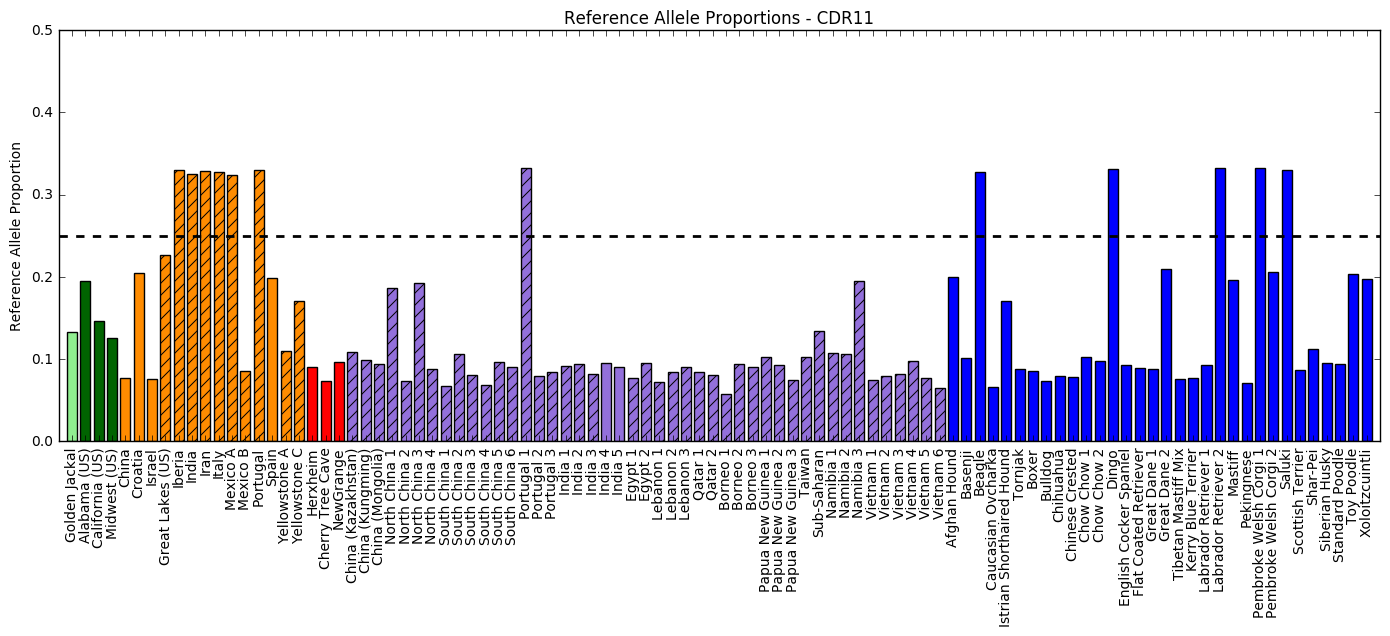

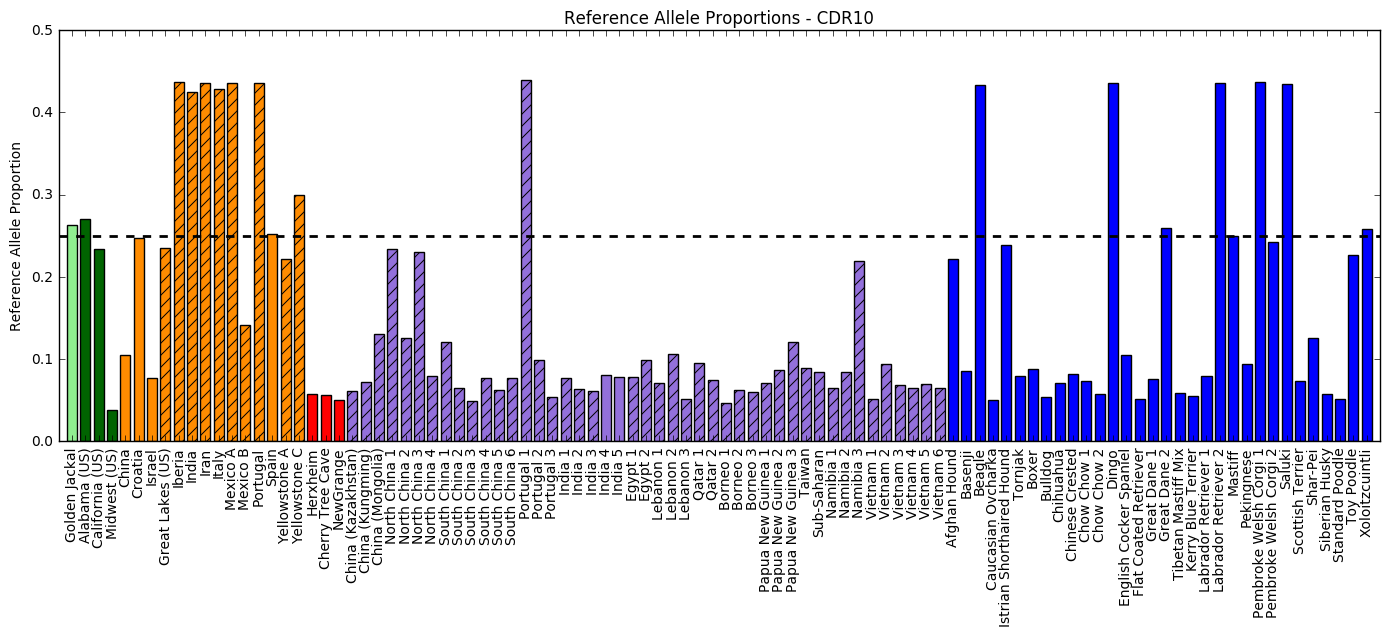

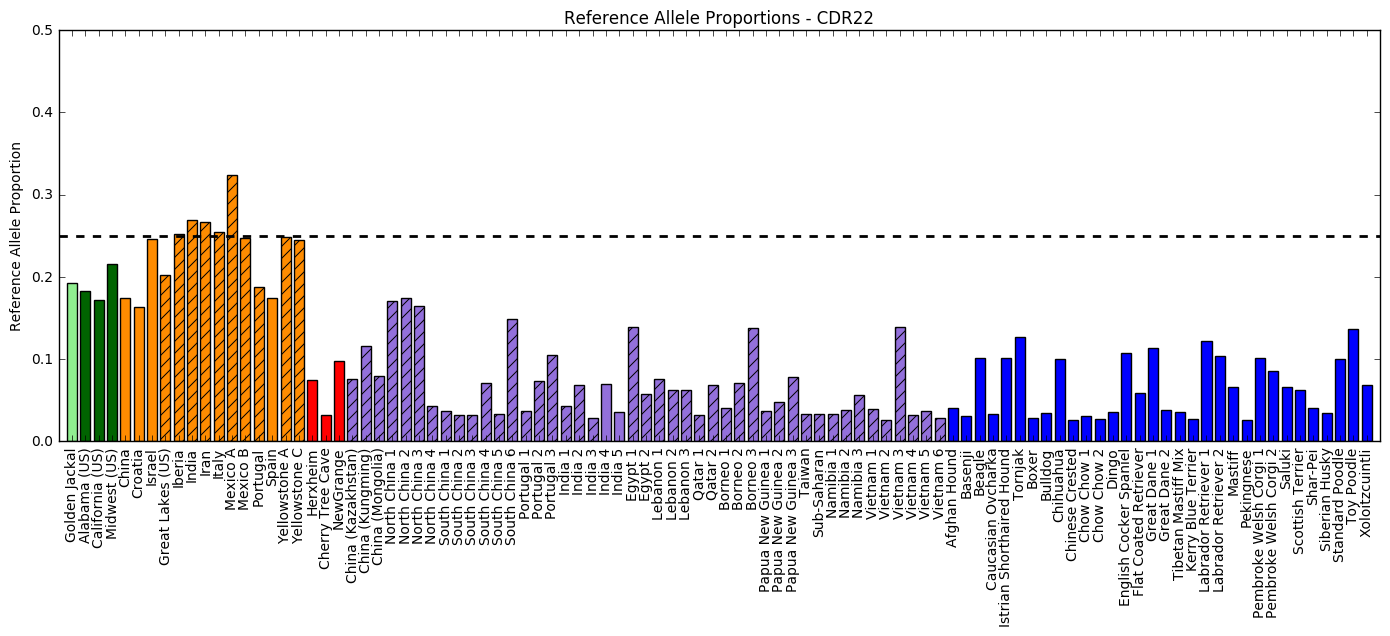

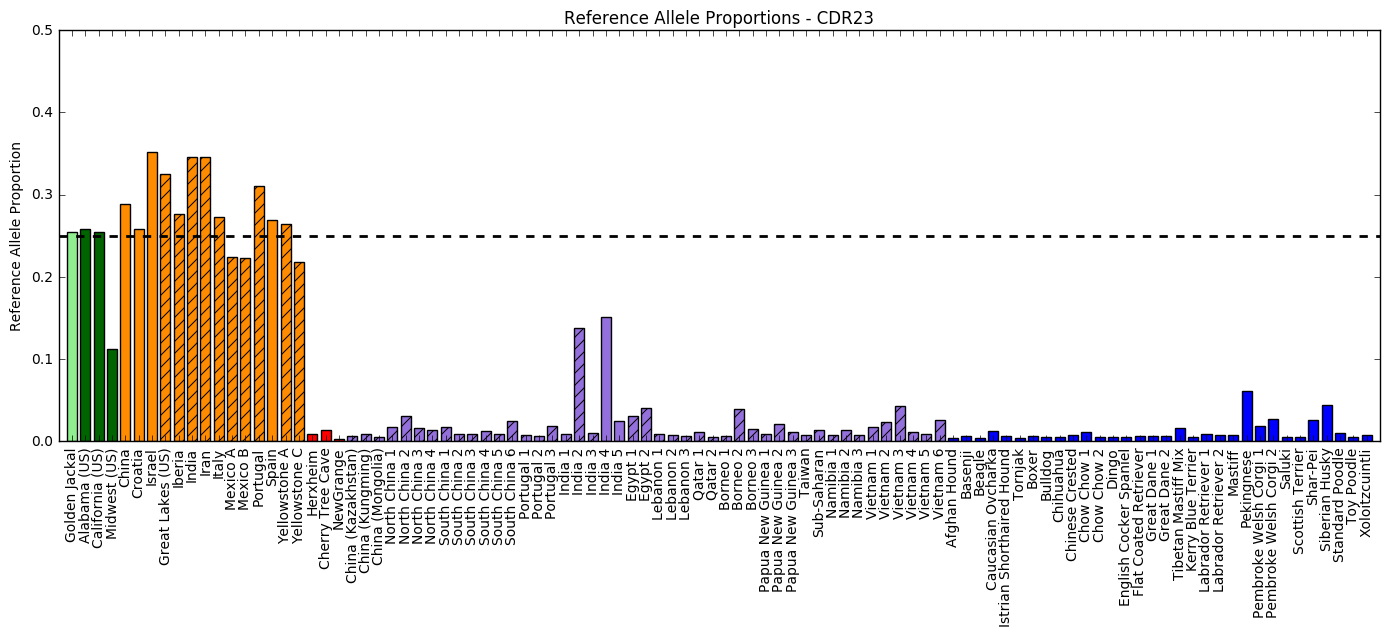

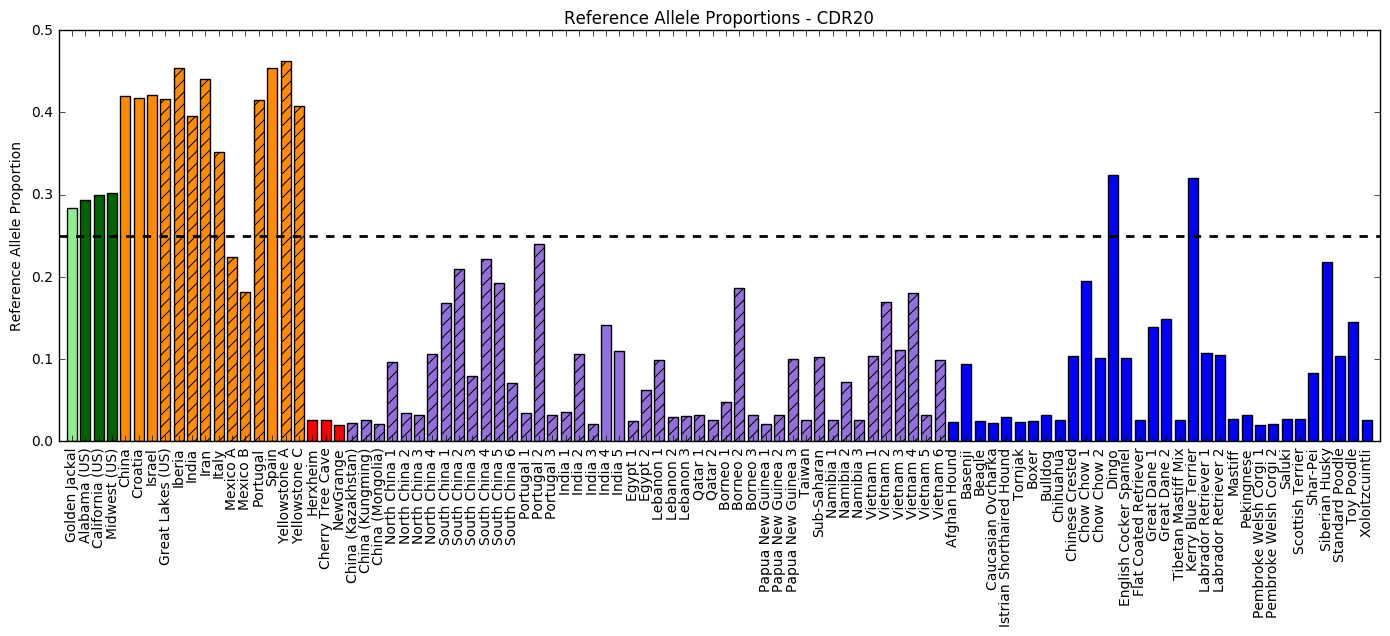

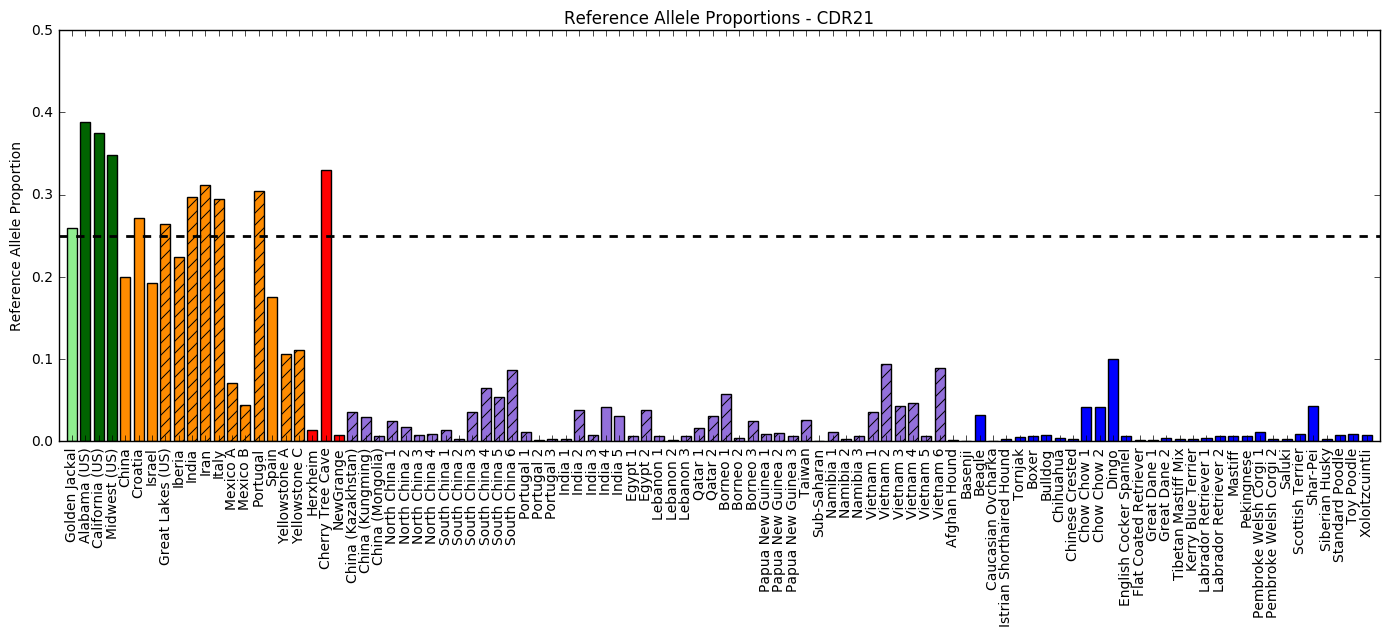

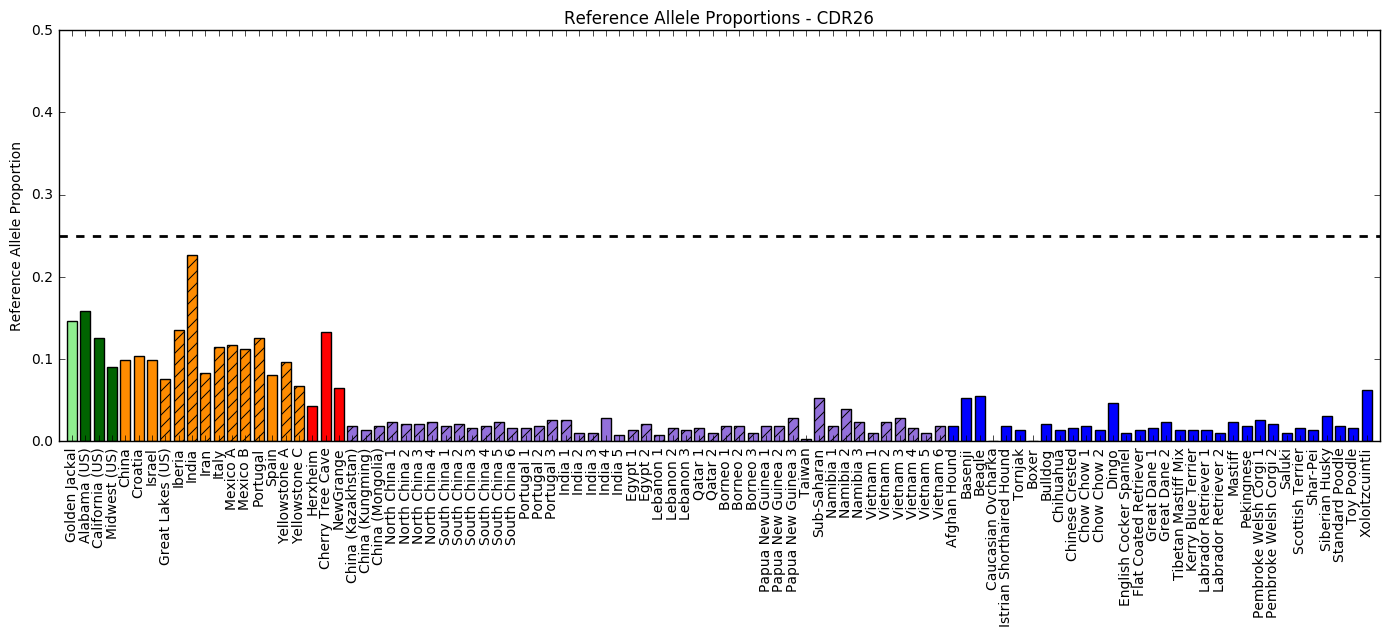

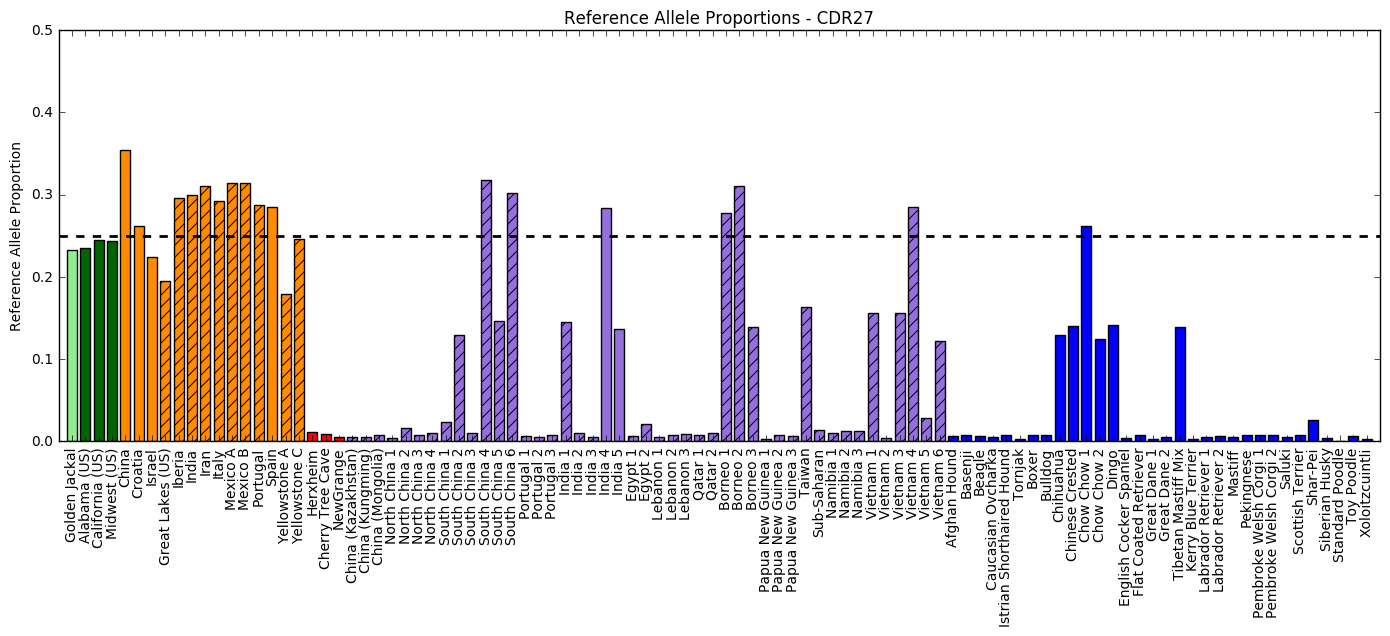

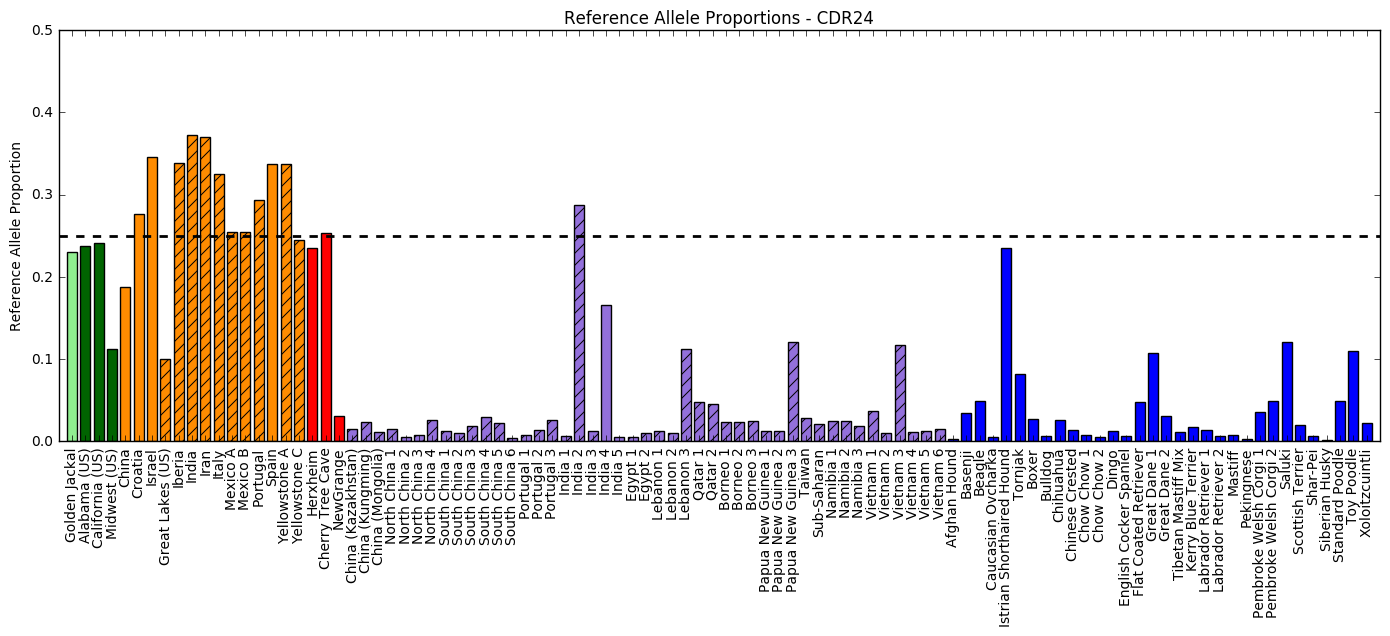

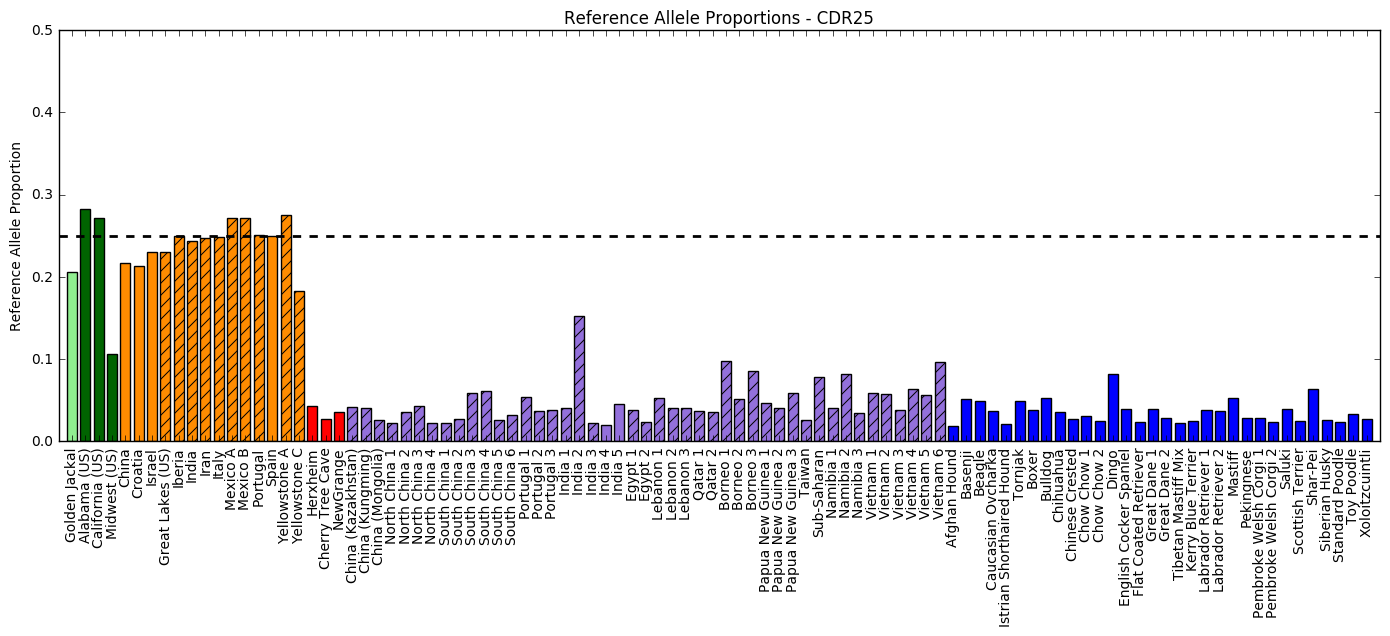

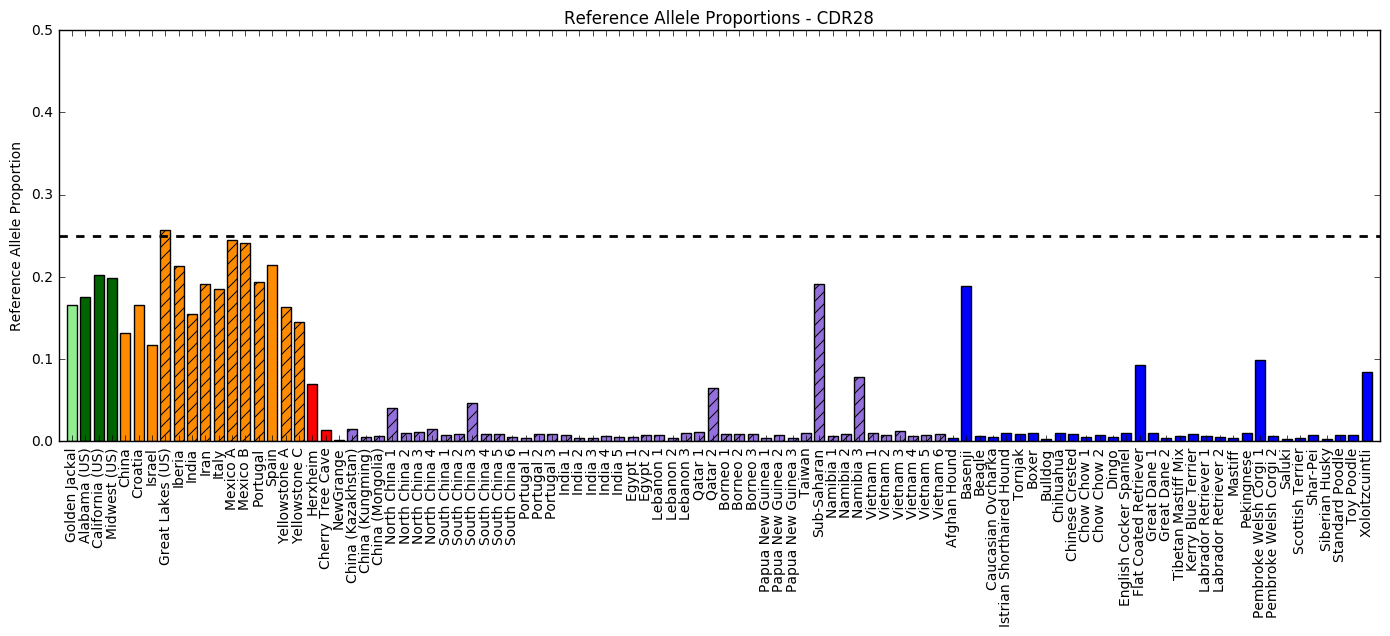

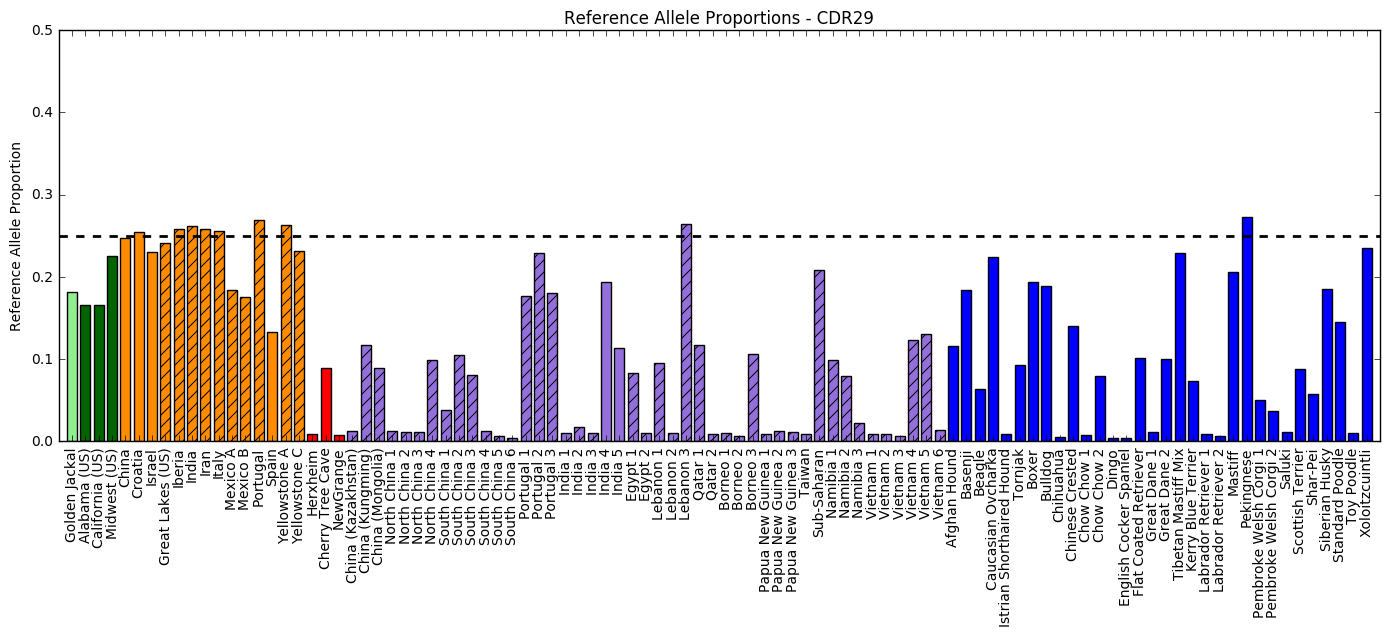

In [56]:
for CDR in propData:
    data = {}
    for i in range(0,len(propData[CDR])):
        dog = dogs[i]
        data[dog] = [propData[CDR][i]]
    print CDR
    #PLOTTING
    labelFont  = {'fontname':'Arial'}
    width = .75
    #CLEARING OUT VARIABLES
    names = []
    ticks = []
    labels = {}
    labels['Fox']  =1 
    plt.figure(figsize=(14,6))
    #For keeping track of ymax
    Ymax = []
    for i in range(len(RDplotOrder)):
        canineType = RDplotOrder[i][2]
        sample = RDplotOrder[i][0]
        if canineType == 'Fox':
            color = 'lightgreen'
        elif canineType == 'Jackal':
            color = 'lightgreen'
        elif canineType == 'Coyote':
            color = 'darkgreen'
        elif canineType == 'Wolf':
            color = 'darkorange'
        elif canineType == 'AncientDog':
            color = 'red'
        elif canineType == 'Village Dog':
            color = 'mediumpurple'
        elif canineType == 'Breed':
            color = 'blue'
        elif canineType == 'New Guinea Singing Dog':
            color = 'steelblue'
        else:
            color = 'mediumpurple'
        if canineType in labels:
            if sample in fstDogs:
                _ = plt.bar(i,(1-get_ref_prop(RDplotOrder[i][0],data)),width,align='center',color=color, hatch = '//')
            else:
                _ = plt.bar(i,(1-get_ref_prop(RDplotOrder[i][0],data)),width,align='center',color=color)
        else:
            l = RDplotOrder[i][2]
            labels[l] = 1
            if l == 'Jackal':
                l = 'Fox and Jackal'
            if l == 'AncientDog':
                l = 'Ancient Dog'
            if l == 'VillageDog':
                l = 'Village Dog'
            if sample in fstDogs:
                _ = plt.bar(i,(1-get_ref_prop(RDplotOrder[i][0],data)),width,align='center',color=color, hatch = '//')
            else:
                _ = plt.bar(i,(1-get_ref_prop(RDplotOrder[i][0],data)),width,align='center',color=color)
            
            #_ = plt.bar(i,get_ref_prop(RDplotOrder[i][0],data),width,align='center',color=color,label=l)
        #Add the Ymax to the array 
        Ymax.append((1-get_ref_prop(RDplotOrder[i][0],data)))
        names.append(RDplotOrder[i][4])
        ticks.append(i)


    _ =plt.xticks(ticks,names,rotation=90)
    _ = plt.xlim([-1,ticks[-1]+1])
    _ = plt.yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    #_ = plt.ylim([0,(max(Ymax)+.1)])
    _ = plt.ylim([0,0.5])

    plt.legend(loc=2)

    plt.axhline(y=.25,color='black',linestyle='--',linewidth=2)
    #ADDING LABELS TO AXES AND TITLE TO PLOT
    plt.ylabel('Reference Allele Proportion')
    plt.title('Reference Allele Proportions - %s' % CDR)

    #MAKING LEGEND AT BOTTOM OF PlOT
    ax = plt.subplot(111)
    x = np.arange(10)
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5),fancybox=True, shadow=True, ncol=6)
    #GENERATING PLOT
    plt.tight_layout()
    plt.savefig(directory + CDR + '_ReferenceAllelePlot_shaded.png')